## 1. File description 




## 0. Import module and setting notebook preferences

### 0.1 Import modules

In [1]:
import src.useful as su
import src.labelling as sl
import src.image as si
import src.model as sm 
import src.webscraping as sw
import src.viz as sv

import sqlite3
import pandas as pd 
import numpy as np
from scipy.stats import boxcox

import plotly.io as pio
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import dtale
# from autoviz import data_cleaning_suggestions



from sklearn.preprocessing import OneHotEncoder

import re
import os
from pandarallel import pandarallel

pandarallel.initialize()
sl.Mypandas.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### 0.2 Notebook preferences

In [2]:
# Setting pandas options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,}'.format

# Setting plotly as dark
pio.templates.default = "plotly_dark"
plotly_kwargs = {'category_orders': {"label": [0, 1, 3]},
                 'color_discrete_sequence': ['#00CC96', '#EF553B', '#FECB52']}

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

### 0.3 Load and consolidate the data into a single table


In [3]:
df_main = sl.load_main()
df_labels = sl.load_labels()
 
df_main = df_main.merge(df_labels, how='left', on='username')

# either fillna, either dropna, depending on the use case, comment/uncomment
# df_main['label'] = df_main['label'].fillna(2).astype(int)
# df_main['label'] = df_main['label'].astype(str)
df_main['binary_label'] = df_main['label'].apply(lambda x: 1 if x == 3 else x)
df_main = df_main.dropna(subset='label').reset_index(drop=True)

# df_main = sl.Mypandas(df_main)
df_main.head()

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837","73,317,785.99997014","4,082.0",14.0,"29,077.0",583.0,"48,506.0",1.0,170.08333333333334,0.5833333333333334,"1,211.5416666666667",24.291666666666668,"2,021.0833333333333",0.041666666666666664,40.0,0.0,0.0,2.0,2020-06-09 23:34:44,0.0,356.0,1.0,"5,919.0",94.0,2022-10-06 13:37:50,1.0,"201,143,127,253,196,356,90,298,247,223,91,78,2...","1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1","5919,822,1509,0,0,0,1728,0,0,3396,1397,2206,0,...","6.0,39.0,27.0,19.0,3.0,94.0,13.0,19.0,24.0,9.0...","2021-08-04 17:42:55,2022-10-06 13:37:50,2022-1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0",0.0,0.0,label_tbl_fake,0.0
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,None,None,Video creator,None,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,None,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,None,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,161,😂,1,1,180,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,221.88200231501833,"5,325.16805556044","19,170,605.000017583","1,127.0",0.0,0.0,15.0,"12,119.0",4.0,187.83333333333334,0.0,0.0,2.5,"2,019.8333333333333",0.6666666666666666,127.0,0.0,0.0,1.0,2019-10-20 18:00:37,0.0,246.0,0.0,0.0,6.0,2020-05-29 15:10:42,1.0,"246,231,202,193,128,127","0,0,0,0,0,0","0,0,0,0,0,0","2.0,2.0,2.0,6.0,1.0,2.0","2020-05-29 15:10:42,2020-04-11 19:04:58,2020-0...","0,1,0,1,1,1",0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
4,festive-uppish-leech,stay mad bum,stay mad bum,,0.0,0.0,0.0,0.0,None,None,k

In [4]:
# asdf

### 0.4 Counting labels

In [5]:
unique_comments = df_main.shape[0]
unique_usernames = df_main.drop_duplicates(subset='username').shape[0]

labels = df_main['label'].value_counts()
labels_unique = df_main.drop_duplicates(subset='username')['label'].value_counts()


print(f'{unique_comments = }')
print(f'{unique_usernames = }\n')
print(f'Labels for comment \n{labels}\n')
print(f'Labels unique users \n{labels_unique}\n\n')
print(f'% comments labelled: {sum(labels)/unique_comments:.1%}')
print(f'% users labelled: {sum(labels_unique)/unique_usernames:.1%}')

unique_comments = 30536
unique_usernames = 14586

Labels for comment 
0.0    18625
1.0    10931
3.0      980
Name: label, dtype: int64

Labels unique users 
0.0    11223
1.0     2865
3.0      498
Name: label, dtype: int64


% comments labelled: 100.0%
% users labelled: 100.0%


## 1.0 Quick viz 

### 1.X Pandas profiling

In [6]:
# Generate report of the data
# profile = ProfileReport(df_main, title="Pandas Profiling Report")
# profile.to_file('data/pandas_profiling.html')

In [7]:
df_main.head()

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837","73,317,785.99997014","4,082.0",14.0,"29,077.0",583.0,"48,506.0",1.0,170.08333333333334,0.5833333333333334,"1,211.5416666666667",24.291666666666668,"2,021.0833333333333",0.041666666666666664,40.0,0.0,0.0,2.0,2020-06-09 23:34:44,0.0,356.0,1.0,"5,919.0",94.0,2022-10-06 13:37:50,1.0,"201,143,127,253,196,356,90,298,247,223,91,78,2...","1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1","5919,822,1509,0,0,0,1728,0,0,3396,1397,2206,0,...","6.0,39.0,27.0,19.0,3.0,94.0,13.0,19.0,24.0,9.0...","2021-08-04 17:42:55,2022-10-06 13:37:50,2022-1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0",0.0,0.0,label_tbl_fake,0.0
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,None,None,Video creator,None,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,None,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,None,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,161,😂,1,1,180,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,0.0,0.0,221.88200231501833,"5,325.16805556044","19,170,605.000017583","1,127.0",0.0,0.0,15.0,"12,119.0",4.0,187.83333333333334,0.0,0.0,2.5,"2,019.8333333333333",0.6666666666666666,127.0,0.0,0.0,1.0,2019-10-20 18:00:37,0.0,246.0,0.0,0.0,6.0,2020-05-29 15:10:42,1.0,"246,231,202,193,128,127","0,0,0,0,0,0","0,0,0,0,0,0","2.0,2.0,2.0,6.0,1.0,2.0","2020-05-29 15:10:42,2020-04-11 19:04:58,2020-0...","0,1,0,1,1,1",0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0
4,festive-uppish-leech,stay mad bum,stay mad bum,,0.0,0.0,0.0,0.0,None,None,k

### 1.X dtale

In [8]:
# dtale.show(df_main)

### 1.x Autoviz

In [9]:
# import matplotlib.cm
# cmap = matplotlib.cm.get_cmap('Reds')
def left_subtract(l1,l2):
    lst = []
    for i in l1:
        if i not in l2:
            lst.append(i)
    return lst
def data_suggestions(data):
    """
    Modified by Ram Seshadri. Original idea for data suggestions module was a Kaggler.
    Many thanks to: https://www.kaggle.com/code/itkin16/catboost-on-gpu-baseline
    """
    maxx = []
    minn = []
    all_cols = list(data)
    cat_cols1 = data.select_dtypes(include='object').columns.tolist()
    cat_cols2 = data.select_dtypes(include='category').columns.tolist()
    cat_cols = list(set(cat_cols1+cat_cols2))
    ### The next line may look odd but due to different versions of pandas which
    ### treat the definition of float differently, I am forced to use this. Don't change it.
    num_cols = data.select_dtypes(include='float16').columns.tolist() + data.select_dtypes(
                    include='float32').columns.tolist() + data.select_dtypes(include='float64').columns.tolist()
    non_num_cols = left_subtract(all_cols, num_cols)
    for i in data.columns:
        if i not in cat_cols:
            ### for float and integer, no need to calculate this ##
            minn.append(0)
        else:
            minn.append(data[i].value_counts().min())
    length = len(data)
    nunik = data.nunique()
    nulls = data.isna().sum()
    df = pd.DataFrame(
        {
         #'column': list(data),
        'Nuniques': nunik,
         'NuniquePercent': (100*(nunik/length)),
         'dtype': data.dtypes,
         'Nulls' : nulls,
         'Nullpercent' : 100*(nulls/length),
         'Value counts Min':minn
        },
        columns = ['Nuniques', 'dtype','Nulls','Nullpercent', 'NuniquePercent',
                       'Value counts Min'])
    newcol = 'Data cleaning improvement suggestions'
    print('%s. Complete them before proceeding to ML modeling.' %newcol)
    mixed_cols = [col for col in data.columns if len(data[col].apply(type).value_counts()) > 1]
    df[newcol] = ''
    df['first_comma'] = ''
    if len(cat_cols) > 0:
        mask0 = df['dtype'] == 'object'
        mask1 = df['Value counts Min']/df['Nuniques'] <= 0.05
        mask4 = df['dtype'] == 'category'
        df.loc[mask0&mask1,newcol] += df.loc[mask0&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask4&mask1,newcol] += df.loc[mask4&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask0&mask1,'first_comma'] = ', '
        df.loc[mask4&mask1,'first_comma'] = ', '
    mask2 = df['Nulls'] > 0
    df.loc[mask2,newcol] += df.loc[mask2,'first_comma'] + 'fill missing'
    df.loc[mask2,'first_comma'] = ", "
    mask3 = df['Nuniques'] == 1
    df.loc[mask3,newcol] += df.loc[mask3,'first_comma'] + 'invariant values: drop'
    df.loc[mask3,'first_comma'] = ", "
    if len(non_num_cols) > 0:
        for x in non_num_cols:
            if df.loc[x, 'NuniquePercent'] == 100:
                df.loc[x, newcol] += df.loc[x,'first_comma'] + 'possible ID column: drop'
                df.loc[x,'first_comma'] = ", "
    mask5 = df['Nullpercent'] >= 90
    df.loc[mask5,newcol] += df.loc[mask5,'first_comma'] + 'very high nulls percent: drop'
    df.loc[mask5,'first_comma'] = ", "
    #### check for infinite values here #####
    inf_cols1 = np.array(num_cols)[[(data.loc[(data[col] == np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols2 = np.array(num_cols)[[(data.loc[(data[col] == -np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols = list(set(inf_cols1+inf_cols2))
    ### Check for infinite values in columns #####
    if len(inf_cols) > 0:
        for x in inf_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'infinite values: drop'
            df.loc[x,'first_comma'] = ", "
    #### Check for skewed float columns #######
    skew_cols1 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 1
                    ) & (np.abs(np.round(data[col].skew(), 1)) <= 5) for col in num_cols]].tolist()
    skew_cols2 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 5) for col in num_cols]].tolist()
    skew_cols = list(set(skew_cols1+skew_cols2))
    ### Check for skewed values in columns #####
    if len(skew_cols1) > 0:
        for x in skew_cols1:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'skewed: cap or drop outliers'
            df.loc[x,'first_comma'] = ", "
    if len(skew_cols2) > 0:
        for x in skew_cols2:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'highly skewed: drop outliers or do box-cox transform'
            df.loc[x,'first_comma'] = ", "
    ##### Do the same for mixed dtype columns - they must be fixed! ##
    if len(mixed_cols) > 0:
        for x in mixed_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'fix mixed data types'
            df.loc[x,'first_comma'] = ", "
    df.drop('first_comma', axis=1, inplace=True)
    return df
###################################################################################
def data_cleaning_suggestions(df):
    """
    This is a simple program to give data cleaning and improvement suggestions in class AV.
    Make sure you send in a dataframe. Otherwise, this will give an error.
    """
    if isinstance(df, pd.DataFrame):
        dfx = data_suggestions(df)
        all_rows = dfx.shape[0]
        ax = dfx.head(all_rows).style.background_gradient()  
        display(ax);
    else:
        print("Input must be a dataframe. Please check input and try again.")
###################################################################################

In [10]:
exclude_cols = ['username', 'biography', 'follow_count'] + [col for col in df_main.columns if isinstance(df_main.loc[0, col], (dict, list))]
data_cleaning_suggestions(df_main.drop(exclude_cols, axis=1))

Data cleaning improvement suggestions. Complete them before proceeding to ML modeling.


,Nuniques,dtype,Nulls,Nullpercent,NuniquePercent,Value counts Min,Data cleaning improvement suggestions
biography_wo_emoji,10965,object,0,0.000000,35.908436,1,combine rare categories
biography_emoji,6295,object,0,0.000000,20.615012,1,combine rare categories
biography_emoji_count,30,float64,0,0.000000,0.098245,0,skewed: cap or drop outliers
biography_emoji_count_distinct,25,float64,0,0.000000,0.081871,0,skewed: cap or drop outliers
follower_count,4364,float64,0,0.000000,14.291328,0,highly skewed: drop outliers or do box-cox transform
pronouns,59,object,29931,98.018732,0.193215,1,"combine rare categories, fill missing, very high nulls percent: drop, fix mixed data types"
domain,813,object,12449,40.768274,2.662431,1,"combine rare categories, fill missing, fix mixed data types"
comment,22848,object,0,0.000000,74.823160,1,combine rare categories
comment_wo_emoji,19848,object,0,0.000000,64.998690,1,combine rare categories
comments_likes,2802,int64,0,0.000000,9.176054,0,


In [11]:
os.system('say "auto viz done"')

0

## 1.0 Data cleaning and Univariate Analysis

In [12]:
# df_main.describe_column_by_label

### 1.x Missing values

In [13]:
fill_cat_columns = ['biography', 'domain', 'business_contact_method']

for column in fill_cat_columns: 
    df_main[column] = df_main[column].fillna('MISSING')

In [14]:
# df_main.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### 1.x Follow count

In [15]:
df_main.label.isna().sum()

0

In [16]:
def split_df_by_colcat(self, col): 
    '''Subset a df info multiple each having one label. 
    It returns n dfs, n being number of labels'''
    return [self.query(f'{col} == {category}') for category in sorted(self[col].unique())]


sorted(df_main['label'].unique())

[0.0, 1.0, 3.0]

In [17]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('follow_count')

print('Follow count: ')
display(sub_df.style.format('{:,}'))
fig

Follow count: 


,0.000000,1.000000,3.000000
count,"18,625","10,931",980
mean,922,300,"1,762"
std,"1,229",932,"1,140"
min,0,0,4
25%,231,6,"1,096"
50%,532,33,"1,614"
75%,"1,023",228,"2,191"
max,"7,508","7,350","7,501"


In [18]:
sub_df = df_main.copy(deep=True)
sub_df['follow_count_boxcox'] = boxcox(sub_df['follow_count'], 0.5)

fig = px.histogram(sub_df,
                   x="follow_count", 
                   nbins=500,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug)
                   title='Distribution of the follow count per label',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
fig

The distribution of the follow count is very interesting. All labels' interquartile range (between Q1 and Q3) occupy the 0-2.5k follow count range. the main category of bots (sex bots, main obj of the project) tend to follow between 0 and 243 accounts. from 240 to 1,030 there are the legit users and from 1100 to 2.2k, the other type of bot. 


The bots (1) tend to be more about mass commenting, that's how they scam people
The legit user have a larger distribution and are more diverse
The other type of bot have a higher distribution.

### 1.x Follower count

The upper bound is kinda low. It's not really hard to reach 2.5k followers on IG.

In [19]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('follower_count')

print('Follower count: ')
display(sub_df.style.format('{:,}'))
fig

Follower count: 


,0.000000,1.000000,3.000000
count,"18,625","10,931",980
mean,"26,518",545,"2,453"
std,"310,067",539,"2,446"
min,0,0,0
25%,282,217,"1,219"
50%,729,406,"1,558"
75%,"2,518",635,"2,795"
max,"30,442,605","6,373","14,039"


Seeing the bots at 6k max follower and other bots at 14k, I can assume that none, even if not labelled, can have more than 30k followers

In [20]:
df_main.query('label > 0').sort_values('follower_count', ascending=False).head()

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label
4827,bipedal-funny-orangutan,🇨🇦🇺🇸dm on how to make $5000 weekly \n▪️📚 busin...,dm on how to make $5000 weekly \n business man...,📚🇨🇦🇺🇸📉▪️⛏📊,10.0,7.0,"2,130.0","14,039.0",None,MISSING,"$5,000 for the first five people to dm me “str...","$5,000 for the first five people to dm me “str...",0,💸🇨🇦🇺🇸,3,3,45,25.0,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Financial Consultant,None,1.0,0.0,123.18653935194016,"2,956.4769444465637","10,643,317.00000763","5,494.0",1.0,"1,014.0",32.0,"24,252.0",11.0,457.8333333333333,0.08333333333333333,84.5,2.6666666666666665,"2,021.0",0.9166666666666666,18.0,0.0,0.0,0.0,2021-08-02 16:50:33,0.0,"1,009.0",1.0,"1,014.0",13.0,2021-12-03 21:19:10,1.0,"840,18,952,170,1009,362,356,525,307,306,332,317","0,0,0,0,0,1,0,0,0,0,0,0","0,0,0,0,0,1014,0,0,0,0,0,0","13.0,0.0,11.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0","2021-12-03 21:19:10,2021-10-20 23:13:32,2021-0...","1,1,1,1,1,0,1,1,1,1,1,1",0.0,3.0,comment,1.0
3540,bipedal-funny-orangutan,🇨🇦🇺🇸dm on how to make $5000 weekly \n▪️📚 busin...,dm on how to make $5000 weekly \n business man...,📚🇨🇦🇺🇸📉▪️⛏📊,10.0,7.0,"2,130.0","14,039.0",None,MISSING,"$5,000 for the first five people to dm me “str...","$5,000 for the first five people to dm me “str...",0,💸🇨🇦🇺🇸,3,3,43,25.0,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Financial Consultant,None,1.0,0.0,123.18653935194016,"2,956.4769444465637","10,643,317.00000763","5,494.0",1.0,"1,014.0",32.0,"24,252.0",11.0,457.8333333333333,0.08333333333333333,84.5,2.6666666666666665,"2,021.0",0.9166666666666666,18.0,0.0,0.0,0.0,2021-08-02 16:50:33,0.0,"1,009.0",1.0,"1,014.0",13.0,2021-12-03 21:19:10,1.0,"840,18,952,170,1009,362,356,525,307,306,332,317","0,0,0,0,0,1,0,0,0,0,0,0","0,0,0,0,0,1014,0,0,0,0,0,0","13.0,0.0,11.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0","2021-12-03 21:19:10,2021-10-20 23:13:32,2021-0...","1,1,1,1,1,0,1,1,1,1,1,1",0.0,3.0,comment,1.0
4503,bipedal-funny-orangutan,🇨🇦🇺🇸dm on how to make $5000 weekly \n▪️📚 busin...,dm on how to make $5000 weekly \n business man...,📚🇨🇦🇺🇸📉▪️⛏📊,10.0,7.0,"2,130.0","14,039.0",None,MISSING,"$5,000 for the first five people to dm me “str...","$5,000 for the first five people to dm me “str...",0,💸🇨🇦🇺🇸,3,3,53,25.0,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Financial Consultant,None,1.0,0.0,123.18653935194016,"2,956.4769444465637","10,643,317.00000763","5,494.0",1.0,"1,014.0",32.0,"24,252.0",11.0,457.8333333333333,0.08333333333333333,84.5,2.6666666666666665,"2,021.0",0.9166666666666666,18.0,0.0,0.0,0.0,2021-08-02 16:50:33,0.0,"1,009.0",1.0,"1,014.0",13.0,2021-12-03 21:19:10,1.0,"840,18,952,170,1009,362,356,525,307,306,332,317","0,0,0,0,0,1,0,0,0,0,0,0","0,0,0,0,0,1014,0,0,0,0,0,0","13.0,0.0,11.0,1.0

In [21]:
follower_count_q95 = df_main.follower_count.quantile(.95)
follower_count_q90 = df_main.follower_count.quantile(.90)


fig = px.histogram(df_main.query('follower_count < 30000'), 
                   x="follower_count", 
                   nbins=200,
                   color="label",
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.<br><sub>Numbers next to lines are the quantiles.',
                   **plotly_kwargs
                #    color_discrete_sequence=px.colors.qualitative.Plotly[3:]
                   )

max_follower_bot = df_main.query('label > 0')['follower_count'].max() * 2

fig = fig.update_layout(barmode='overlay', xaxis_range=(0, max_follower_bot))

fig

In [22]:
fig = px.histogram(df_main.query('follower_count < 25000'), 
                   x="follower_count", 
                   nbins=2000,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', 

                        )
fig

### 1.x Posts count

Same as for the follow_count, there is a difference in the distribution of the follower count. It varies less, with the upper fense of the bots in the IQR of the legit users, and lower than the IQR of the other bots. Very skewed distribution 

In [23]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('post_count')

print('Posts count: ')
display(sub_df.style.format('{:,}'))
fig

Posts count: 


,0.000000,1.000000,3.000000
count,"18,625","10,931",980
mean,"6,731",9,18
std,"420,974",75,70
min,0,0,0
25%,2,0,7
50%,12,6,11
75%,167,9,18
max,"28,728,400","3,233","1,852"


In [24]:
# df_main['post_count']
fig = px.histogram(df_main.query('post_count < 5000'), 
                   x="post_count", 
                   nbins=5000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100))

fig

### 1.x Comment time difference FIND ALL THE OUTLIERS FOR EACH COLUMNS AND ADD A OUTLIER COLUMN FOR THE USERS

In [25]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('comment_time_difference')

print('Comment time diff: ')
display(sub_df.style.format('{:,}'))
fig

Comment time diff: 


,0.000000,1.000000,3.000000
count,"18,625","10,931",980
mean,"2,251",93,645
std,"9,335","1,331","3,608"
min,4,4,6
25%,56,18,40
50%,144,25,103
75%,399,40,303
max,"85,224","70,111","67,532"


In [26]:
# df_main['post_count']
fig = px.histogram(df_main,
                   x="comment_time_difference", 
                   nbins=7000,
                   color="label",
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay')

fig

### 1.x Comment time difference WHATS THE AVERAG DIFFERENCE BETWEEN EACH POST? COULD BE UPLOADED SUPER FAST

In [27]:
def round_or_int(val, **kwargs): 
    if pd.isna(val): 
        return val
    elif val == int(val): 
        return int(val) 
    else:
        return round(val, ndigits=kwargs['ndigits'])

def calculate_posts_time_diff_btw_each(date_concat): 
    if pd.isna(date_concat): 
        return date_concat
    dates = [pd.to_datetime(date) for date in date_concat.split(',')]
    dates = sorted(list(set(dates)))[:12]
    dates_diff = pd.Series(dates).diff().dt.seconds.dropna().reset_index(drop=True)
    dates_diff_summary = dates_diff.describe().apply(round_or_int, ndigits=2).to_dict()
    dates_diff_summary.update({'dates_diff': dates_diff.tolist(),
                               'unique_values': len(set(dates_diff)),
                               'total_values': len(dates_diff)
                               })

    # display(pd.DataFrame({i:[j] for i, j in dates_diff_summary.items()}))
    dates_diff_summary = {'dates_diff_' + i:j for i, j in dates_diff_summary.items()}
    return dates_diff_summary

df_main['posts_diff_btw_each_summary_seconds'] = df_main['posts_concat_posted_time'].parallel_apply(calculate_posts_time_diff_btw_each)
# calculate_posts_time_diff_btw_each(df_main.loc[1, 'posts_concat_posted_time'])
df_posts_diff_btw_each_summary = pd.json_normalize(df_main['posts_diff_btw_each_summary_seconds'])

In [28]:
df_main = pd.concat([df_main, df_posts_diff_btw_each_summary], axis=1)
df_main.head()

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label,posts_diff_btw_each_summary_seconds,dates_diff_count,dates_diff_mean,dates_diff_std,dates_diff_min,dates_diff_25%,dates_diff_50%,dates_diff_75%,dates_diff_max,dates_diff_dates_diff,dates_diff_unique_values,dates_diff_total_values
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837","73,317,785.99997014","4,082.0",14.0,"29,077.0",583.0,"48,506.0",1.0,170.08333333333334,0.5833333333333334,"1,211.5416666666667",24.291666666666668,"2,021.0833333333333",0.041666666666666664,40.0,0.0,0.0,2.0,2020-06-09 23:34:44,0.0,356.0,1.0,"5,919.0",94.0,2022-10-06 13:37:50,1.0,"201,143,127,253,196,356,90,298,247,223,91,78,2...","1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1","5919,822,1509,0,0,0,1728,0,0,3396,1397,2206,0,...","6.0,39.0,27.0,19.0,3.0,94.0,13.0,19.0,24.0,9.0...","2021-08-04 17:42:55,2022-10-06 13:37:50,2022-1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0",0.0,0.0,label_tbl_fake,0.0,"{'dates_diff_count': 11.0, 'dates_diff_mean': ...",11.0,"45,242.64","34,944.32",320.0,"13,435.5","57,356.0","75,534.0","85,840.0","[57356.0, 85840.0, 656.0, 25929.0, 942.0, 6805...",11.0,11.0
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Video creator,None,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,MISSING,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MISSING,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,MISSING,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,161,😂,1,1,180,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MISSING,None,None,None,0.0,0.0

In [29]:
# sub_df = df_main[['dates_diff_follows_pattern', 'post_count', 'label']]

# fig = px.scatter_matrix(sub_df, color='label', title='Pairplot')
# sv.save_plotly_fig(fig)

In [30]:
# # Describing column for each label
# sub_df, fig = df_main.describe_column_by_label('dates_diff_50%')

# print('dates_diff_50%: ')
# display(sub_df.style.format('{:,}'))
# fig

### 1.x df_main.describe_column_by_label

In [31]:
# df_main.describe_column_by_label

### 1.x Biography

In [32]:
df_main['biography'] = df_main['biography'].str.lower()

# Adding comment length and word count
df_main['biography_length'] = df_main['biography'].str.len()
df_main['biography_word_count'] = df_main['biography'].str.count(' ') + 1
df_main['biography_linebreak_count'] = df_main['biography'].str.count('\n')


# Adding flag for specific words like sex only, exclusive, etc

df_main.head()



# how many \n and \t

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label,posts_diff_btw_each_summary_seconds,dates_diff_count,dates_diff_mean,dates_diff_std,dates_diff_min,dates_diff_25%,dates_diff_50%,dates_diff_75%,dates_diff_max,dates_diff_dates_diff,dates_diff_unique_values,dates_diff_total_values,biography_length,biography_word_count,biography_linebreak_count
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837","73,317,785.99997014","4,082.0",14.0,"29,077.0",583.0,"48,506.0",1.0,170.08333333333334,0.5833333333333334,"1,211.5416666666667",24.291666666666668,"2,021.0833333333333",0.041666666666666664,40.0,0.0,0.0,2.0,2020-06-09 23:34:44,0.0,356.0,1.0,"5,919.0",94.0,2022-10-06 13:37:50,1.0,"201,143,127,253,196,356,90,298,247,223,91,78,2...","1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1","5919,822,1509,0,0,0,1728,0,0,3396,1397,2206,0,...","6.0,39.0,27.0,19.0,3.0,94.0,13.0,19.0,24.0,9.0...","2021-08-04 17:42:55,2022-10-06 13:37:50,2022-1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0",0.0,0.0,label_tbl_fake,0.0,"{'dates_diff_count': 11.0, 'dates_diff_mean': ...",11.0,"45,242.64","34,944.32",320.0,"13,435.5","57,356.0","75,534.0","85,840.0","[57356.0, 85840.0, 656.0, 25929.0, 942.0, 6805...",11.0,11.0,73,13,3
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Video creator,None,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,23,2
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,MISSING,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MISSING,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2,0
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,MISSING,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,1

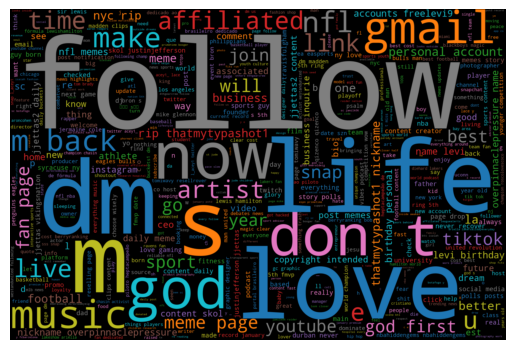

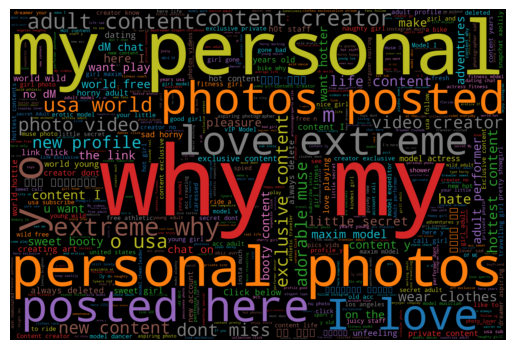

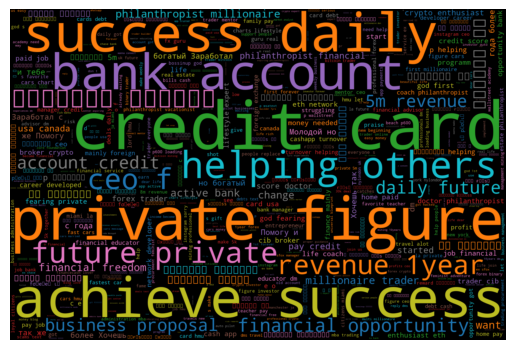

In [52]:
# Plot wordcloud
for num in (0,1,3):
    wordcloud = WordCloud(width=1800, 
                          height=1200, 
                          min_font_size=1, 
                          max_words=500, 
                          colormap='tab10')
                          
    word_list = ' '.join([word for list in df_main.query(f'label == {num}')['biography_wo_emoji'].str.split(' ') for word in list])
    wordcloud.generate(word_list)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### 1.1 Comments

In [34]:
# # lowering everything 
# for column in df_main.select_dtypes('object').columns: 
#     if 'comment' in column: 
#         df_main[column] = df_main[column].str.lower()
#         print(f'Lowered {column}')


# # Adding comment length and word count
# df_main['comment_length'] = df_main['comment'].str.len()
# df_main['comment_word_count'] = df_main['comment'].str.count(' ') + 1


# # Adding flag for specific wordlike sex only, exclusive, etc

# df_main.head()

In [35]:
all_words = [word for list in df_main['biography'].str.split(' ') for word in list]
print(f'Total words: {len(all_words):,}')
print(f'Unique words: {len(set(all_words)):,}')

Total words: 259,434
Unique words: 42,755


In [36]:
# # Plot wordcloud
# for num in (0,1,3):
#     wordcloud = WordCloud(width=1800, 
#                           height=1200, 
#                           min_font_size=1, 
#                           max_words=500, 
#                           colormap='tab10')
                          
#     word_list = ' '.join([word for list in df_main.query(f'label == {num}')['comment_wo_emoji'].str.split(' ') for word in list])
#     wordcloud.generate(word_list)
#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

In [37]:
#### HERE MAKE A VLAUE COUNT FOR EACH LABEL

* Both legit and other bots have the word "first", but not for the same reason. For the legits, its only to be first to comment where for the bots it's the first who read out to them. Let's check the average sentence length where first is in. 

In [38]:
# for num in (0, 1, 3):
#     mean = df_main.query(f'comment.str.contains("first") and label == {num}')['comment_word_count'].mean()
#     print(f'Mean for {num}: {round(mean)}')

### 1.x Business/Verified

There are multiple columns like: `is_business_account`, `is_professional_account`, `category_enum`, `category_name`, `business_category_name`, `business_contact_method`

In [39]:
business_columns = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 'business_contact_method']

sub_df = df_main[business_columns + ['label']]

for col in business_columns: 
    col_na = sub_df[col].isna()
    if col_na.sum() != 0:
        sub_df[col] = sub_df[col].isna().astype(int)

sub_df.groupby(business_columns, as_index=False)['label'].count()

/var/folders/52/s1w1p2q558xfjlyyyjlbfphr0000gn/T/ipykernel_16115/1305034588.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,is_business_account,is_professional_account,category_enum,category_name,business_category_name,business_contact_method,label
0,0.0,0.0,1,1,1,MISSING,20398
1,0.0,0.0,1,1,1,UNKNOWN,1327
2,0.0,1.0,1,0,1,CALL,189
3,0.0,1.0,1,0,1,MISSING,5068
4,0.0,1.0,1,0,1,TEXT,91
5,0.0,1.0,1,0,1,UNKNOWN,503
6,0.0,1.0,1,1,1,MISSING,3
7,1.0,1.0,0,0,0,CALL,428
8,1.0,1.0,0,0,0,MISSING,1546
9,1.0,1.0,0,0,0,TEXT,154


In [40]:
df_business_groupby = df_main.groupby(['is_professional_account', 'is_business_account', 'label'], as_index=False)['username'].count()
df_business_groupby['count_%'] = df_business_groupby['username'] / df_business_groupby['username'].sum()

df_business_groupby.style.background_gradient()

,is_professional_account,is_business_account,label,username,count_%
0,0.000000,0.000000,0.000000,10707,0.350635
1,0.000000,0.000000,1.000000,10571,0.346182
2,0.000000,0.000000,3.000000,447,0.014638
3,1.000000,0.000000,0.000000,5337,0.174777
4,1.000000,0.000000,1.000000,246,0.008056
5,1.000000,0.000000,3.000000,271,0.008875
6,1.000000,1.000000,0.000000,2581,0.084523
7,1.000000,1.000000,1.000000,114,0.003733
8,1.000000,1.000000,3.000000,262,0.008580


Many bots are creating professional or business accounts. Seems like if you're a business, you're a professional but if you're pro, you're not necessarily a business. The highest combination is that most legit users and bots don't have a professional account. It's good to note that for the otherbots, there are as more accounts as professionals/business than normal accounts.

In [41]:
px.sunburst(df_main.dropna(subset='category_enum').fillna('na'),
            path=['category_enum', 'category_name'],
            color='label',
            ).update_layout(uniformtext=dict(minsize=10, mode='hide'))

In [42]:
# asdf

In [47]:
fig = px.histogram(df_main, 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

In [49]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots only')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

In [50]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='business_category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of business_category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
fig

It's interesting to see the difference between the bots and the sex bots. Even though many have been miss labelled (they'll both be marked at 1 when developping the model) bet ween bot or otherbot, there is a significative distinction between how they identify themselves.

Other bots seems to be more entreupreuners, financial service or investment firm where bots are more video creator (you bet), personnal blog or gamer.

In [ ]:
df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True)[df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True).lt(12)].index

In [ ]:
# Keeping only binary columns
df_main = df_main.drop(['category_name', 'business_category_name', 'business_contact_method'], axis=1)

In [51]:
df_main

,username,biography,biography_wo_emoji,biography_emoji,biography_emoji_count,biography_emoji_count_distinct,follow_count,follower_count,pronouns,domain,comment,comment_wo_emoji,comments_likes,comment_emoji,comment_emoji_count,comment_emoji_count_distinct,comment_time_difference,post_count,video_count,highlight_reel_count,hide_like_and_view_counts,has_guides,has_clips,is_private,is_embeds_disabled,is_joined_recently,is_professional_account,is_business_account,business_contact_method,business_category_name,category_name,category_enum,should_show_category,should_show_public_contacts,posts_days_diff,posts_hours_diff,posts_minutes_diff,posts_sum_likes,posts_sum_is_video,posts_sum_video_views,posts_sum_comments,posts_sum_posted_time,posts_sum_tagg_count,posts_avg_likes,posts_avg_is_video,posts_avg_video_views,posts_avg_comments,posts_avg_posted_time,posts_avg_tagg_count,posts_min_likes,posts_min_is_video,posts_min_video_views,posts_min_comments,posts_min_posted_time,posts_min_tagg_count,posts_max_likes,posts_max_is_video,posts_max_video_views,posts_max_comments,posts_max_posted_time,posts_max_tagg_count,posts_concat_likes,posts_concat_is_video,posts_concat_video_views,posts_concat_comments,posts_concat_posted_time,posts_concat_tagg_count,is_verified,label,labelling_technique,binary_label,posts_diff_btw_each_summary_seconds,dates_diff_count,dates_diff_mean,dates_diff_std,dates_diff_min,dates_diff_25%,dates_diff_50%,dates_diff_75%,dates_diff_max,dates_diff_dates_diff,dates_diff_unique_values,dates_diff_total_values,biography_length,biography_word_count,biography_linebreak_count
0,adorable-jade-beluga,⁣⁣28 🇩🇪 🇪🇸 \ncapricorn 🐐 \ndallas tx📍outside 🍾...,⁣⁣28 \ncapricorn \ndallas txoutside \n“her ...,📍🇩🇪🚫🍾🇪🇸🐐,6.0,6.0,"3,164.0","4,676.0",None,mintyswraps.com,bucks finna have a repeat 🏆 👀,bucks finna have a repeat,967,👀🏆,2,2,95,76.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,UNKNOWN,None,None,None,0.0,0.0,848.5854861107655,"20,366.05166665837","73,317,785.99997014","4,082.0",14.0,"29,077.0",583.0,"48,506.0",1.0,170.08333333333334,0.5833333333333334,"1,211.5416666666667",24.291666666666668,"2,021.0833333333333",0.041666666666666664,40.0,0.0,0.0,2.0,2020-06-09 23:34:44,0.0,356.0,1.0,"5,919.0",94.0,2022-10-06 13:37:50,1.0,"201,143,127,253,196,356,90,298,247,223,91,78,2...","1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1","5919,822,1509,0,0,0,1728,0,0,3396,1397,2206,0,...","6.0,39.0,27.0,19.0,3.0,94.0,13.0,19.0,24.0,9.0...","2021-08-04 17:42:55,2022-10-06 13:37:50,2022-1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0",0.0,0.0,label_tbl_fake,0.0,"{'dates_diff_count': 11.0, 'dates_diff_mean': ...",11.0,"45,242.64","34,944.32",320.0,"13,435.5","57,356.0","75,534.0","85,840.0","[57356.0, 85840.0, 656.0, 25929.0, 942.0, 6805...",11.0,11.0,73,13,3
1,hysterical-glistening-bee,“moving at a pace slow for some but fast for o...,“moving at a pace slow for some but fast for o...,⬇️🚨,2.0,2.0,114.0,52.0,None,youtube.com,crazy eyes got moves lol 🤣🤣😭,crazy eyes got moves lol,1024,😭🤣,3,2,250,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,MISSING,None,Video creator,None,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,23,2
2,little-crafty-mink,new page.,new page.,,0.0,0.0,204.0,422.0,None,MISSING,flight is gonna be heated 😂,flight is gonna be heated,711,😂,1,1,310,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,MISSING,None,None,None,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,0.0,0.0,"old_manual_labelling,old_manual_labelling",0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2,0
3,gentle-crimson-wolf,• 9/26 💘 •,• 9/26 •,💘,1.0,1.0,211.0,586.0,None,MISSING,someone forgot to tell the warriors they had a...,someone forgot to tell the warriors they had a...,1

#### IV Changing values

### Pronouns

In [ ]:
sub_df = df_main.copy(deep=True)
sub_df['pronoun_null'] = sub_df['pronouns'].isna().astype(int)

sub_df.groupby(['pronoun_null', 'label'], as_index=False)['username'].count() 

There are still 11 bots that have a pronoun. Which do they identify to you ask??

In [ ]:
df_main.pronouns.value_counts().head()

In [ ]:
pronouns = {"he": 'male', "him": 'male', "his": 'male', "himself": 'male', "she": 'female', "her": 'female', "hers": 'female', "herself": 'female'}

def find_gender(pronoun): 
    if pd.notna(pronoun):
        first_pronoun = re.split(',| ', pronoun)[0]
        try:
            return pronouns[first_pronoun]
        except KeyError: 
            return 'nonbinary'

df_main['pronouns'].apply(find_gender).value_counts()

In [ ]:
df_main = df_main.drop('pronouns', axis=1)

### POst count and video count

### Next

### Comment likes

In [ ]:
def outliers_bound(self, col):
    q1, q3 = self[col].quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def find_outliers(self, col, bounds=[]):
    '''Given a columns, return a pd.Series with True/False for each value'''
    if len(bounds) == 2: 
        lower_bound, upper_bound = bounds
    else: 
        lower_bound, upper_bound = outliers_bound(self, col)

    return self[col].fillna(self[col].quantile(.5)).apply(lambda x: not lower_bound <= x <= upper_bound)


def find_all_outliers(self, dtypes=None, columns=None, exclude=[]):
    # Add or remove column to the list
    if dtypes != None: 
        columns = list(self.select_dtypes(dtypes))
    elif isinstance(columns, str):
        columns = [columns]
    for col in exclude: 
        columns.remove(col)

    # Find outliers and concat
    base_series = pd.Series(['']*self.shape[0])
    for index, col in enumerate(columns): 
        col_outliers = find_outliers(self, col).map({True: col, False: ''})
        base_series = base_series.str.cat(col_outliers, sep=' ').str.strip()
        
    return base_series


find_outliers(df_main, 'comments_likes')

In [ ]:
df_main.outliers_bound('comments_likes')

In [ ]:
for x in df_main.describe_column_by_colcat('comments_likes'): 
    display(x)

In [ ]:
# def better_describe(self, column): 
#     data = {}
#     # data = {'count': [self[column].shape[0]],
#     #         'sum': [self[column].sum()],
#     #         }

#     # data.update({'min': [self[column].min()]})
#     for q in range(1, 100): 
#         data.update({f'{q}%': [self[column].quantile(q/100)]})
#     # data.update({'max': [self[column].max()]})
    

#     df = pd.DataFrame(data).T#.drop_duplicates(0, keep='first')
#     df['diff'] = df.iloc[::-1].diff()
#     df['var'] = [np.nan] + (df['diff'] / df[0] * -1).round(2).tolist()[:-1]

#     return df.query('var >= .1').round(2)


# better_describe(df_main, 'comments_likes').head(50)

* different quantile
* skewness
* inf values
* unique values
* null values
* sum
* quantile 
* count
* Min 
* max
* std
*

There is no doubts on that, bots comment the faster and it's their main strategy which makes sense, the sonner the comment the more reach it has. 

There is a clear distinction between the bots and the other bots. The bots are way more in volume 

In [ ]:
df_main.query('label == 3')['comments_likes']

In [ ]:
fig = px.box(df_main, 
             x='label', 
             y='comments_likes',
             color='label',
             **plotly_kwargs
             )

fig.update_layout(yaxis_range=(0, 600))

In [ ]:
# df = px.data.iris()
# fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", marginal_y="violin",
#            marginal_x="box", trendline="ols", template="simple_white")
# fig.show()

### 1.x Comment time diff

In [ ]:
df_main

In [ ]:
fig = px.violin(df_main, 
                x='label', 
                y='comment_time_difference',
                color='label',
                box=True, 
                # kde=1,
                # meanline_visible=True,
                # points='all',
                **plotly_kwargs
                )

fig.update_layout(yaxis_range=(0, 450))
fig.update_traces(bandwidth=100, selector=dict(type='violin'))

fig

There's a clear distinction between the different labels: legit users tend to comment, even after some time where the bots are way faster. They comment only

The collected data is not representative of the overall population but I think that by collecting more, I would have just extended the range of the `0` class.

### Investigate

In [ ]:
adsf

In [ ]:
# column = 'dates_diff_50%'
# cols_co_keep = [column] + ['username', 'biography', 'label', 'labelling_technique']

# df_main = df_main.query('label > 0').sort_values(column, ascending=False)[cols_co_keep].drop_duplicates()
# display(df_main.head(50))
username = 'solid-naughty-griffin'
# print(sl.load_table('select '))
print(username)

display(sl.load_labels(include_all=True).query('username == @username'))
display(sl.load_table('username_mapping').query('cooler_name == @username'))
df_main.query('username == @username')

### Done investigating

## 2.0 Multi variate analysis

### follow count & follow 

In [ ]:
# df_main.query('comment_time_difference > 74 and label > 0').sort_values('comment_time_difference', ascending=False)[['username', 
#                                                                                                         'post_count', 
#                                                                                                         'comment_time_difference', 
#                                                                                                         'biography', 
#                                                                                                         'label', 
#                                                                                                         'labelling_technique']].head(40)

px.scatter_3d(df_main,
              x='follow_count',
              y='follower_count',
              z='label',
              color='label')

#### 1.1.6 Pairplot

#### 1.1.7

### 2.x Comment likes vs comment time diff

In [ ]:
sub_df = df_main.copy(deep=True)


# sub_df[]

fig = px.scatter(sub_df,
           x='comment_time_difference', 
           y='comments_likes',
           color='label')
# you can be casual and nice to read but remember that the public is from an age of 21 to 100 years old. 
fig.update_layout()

### ?

In [ ]:
percent99 = df_main['follower_count'].quantile(0.9)
sub_df = df_main.query('follower_count < @percent99')


fig = px.histogram(sub_df, 
                   x="follower_count", 
                   nbins=100,
                   color="label",
                   marginal="box", # or violin, rug
                   )

fig.update_layout(barmode='overlay')

In [ ]:
import plotly.figure_factory as ff
import numpy as np

sub_df = df_main.query('follow_count.notna()')


labels = ['0', '1', '3']
hist_data = [sub_df[sub_df['label'] == int(x)]['follow_count'] for x  in labels]

fig = ff.create_distplot(hist_data, labels,
                         bin_size=[200, 200, 200], show_curve=True)

# Add title
fig.update(layout_title_text='Hist and Rug Plot')
fig.show()

## Export df_ml

In [ ]:
# asdlf

In [ ]:
df_ml = df_main.copy(deep=True)

# removing na on label,
df_ml = df_ml.dropna(subset='label')

df_ml['biography'] = df_ml['biography'].fillna('')
df_ml['domain'] = df_ml['domain'].fillna('')
df_ml['pronouns'] = df_ml['pronouns'].fillna('')


# removing agg columns 
df_ml['posts_na_flag'] = df_ml['posts_days_diff'].isna().astype(int)
for col in df_ml.columns: 
    if (col[:6] == 'posts_' and 'concat' not in col and 'posted_time' not in col) or 'dates_diff' in col: 
        try:
            df_ml[col] = df_ml[col].fillna(df_ml[col].mean())
        except: 
            df_ml = df_ml.drop(col, axis=1)
    elif 'concat' in col or 'posted_time' in col: 
        df_ml = df_ml.drop(col, axis=1)

# Adding comment feature 
df_ml['comment_length'] = df_ml['comment'].str.len()

# removing na on follow count
df_ml = df_ml.dropna(subset='follow_count')
df_ml['biography'] = df_ml['biography'].apply(lambda x: 1 if len(x) > 0 else 0)
df_ml['domain'] = df_ml['domain'].apply(lambda x: 1 if len(x) > 0 else 0)
df_ml['pronouns'] = df_ml['pronouns'].apply(lambda x: 1 if len(x) > 0 else 0)
df_ml['label'] = df_ml['label'].astype(float)
df_ml = df_ml.drop(['category_enum', 'category_name', 'business_category_name', 'business_contact_method', 'posts_days_diff', 'posts_hours_diff', 'emoji', 'comment_wo_emoji', 'comment', 'biography', 'labelling_technique', 'domain', 'pronouns'], axis=1)

In [ ]:
df_ml['label'].value_counts()

In [ ]:
df_ml.isna().sum().tail(40)

In [ ]:
df_ml['dates_diff_min'].fillna(df_ml['dates_diff_min'].mean())

In [ ]:
s = df_ml.isna().sum().head(50).eq(0)
cols = s[s].index
cols

In [ ]:
df_ml.to_sql('ml', con, if_exists='replace', index=False)

In [ ]:
# # DUMB ML TEST 
# df_dumb_ml = df_ml.copy(deep=True)


# for col in df_ml.columns: 
#     # print(len(df_ml[col].unique()))
#     unique_vals = df_dumb_ml[col].unique()
#     if 2 < len(unique_vals) < 10000:
#         for x in df_dumb_ml[col].describe().iloc[1:-1]: 
#             df_dumb_ml[col + str(x)] = df_dumb_ml[col].ge(x)
        
#         df_dumb_ml.drop(col, axis=1)

# df_dumb_ml.to_sql('dumb_ml', con, if_exists='replace', index=False)
# df_dumb_ml.shape

In [ ]:
df_ml.head()

### Quick ML

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier, DMatrix
import shap

In [ ]:
df_ml = sl.load_table('dumb_ml').query('label.isin((0, 1, 3))')
df_ml = sl.load_table('ml').query('label.isin((0, 1, 3))')
df_ml['label'] = df_ml['label'].apply(lambda x: 1 if x == 3 else x)
legit_count, bot_count = df_ml['label'].value_counts()
print(f'{legit_count = }\n{bot_count = }')
print(df_ml.shape)

In [ ]:
df_ml.label.value_counts()

In [ ]:
df_ml.head()

In [ ]:
# Split data
X = df_ml.drop(['label', 'username'], axis=1)
y = df_ml['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test =X.iloc[:X.shape[0] // 5 * 4, :], X.iloc[X.shape[0] // 5 * 4:, :], y[:y.shape[0] // 5 * 4], y[y.shape[0] // 5 * 4:]

# Create a random forest classifier
clf = DecisionTreeClassifier(max_depth=1000, criterion='entropy', random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = XGBClassifier(n_estimators=1000,        
                    max_depth=8,
                    n_jobs=-1,
                    eval_metric='auc',
                    random_state=42
                    )

clf.fit(X_train, 
        y_train
        )

# clf.get_params()

In [ ]:
# for x in range(1, 10):
decision_threshold = sm.threshold_finder(model = clf, X = X_test, y_true = y_test)
print(decision_threshold)
y_pred_proba = [x[1] for x in clf.predict_proba(X_test)]
y_pred = (pd.Series(y_pred_proba) > decision_threshold).astype(int)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Test the classifier on the test data
for metric in [accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score]:
    
    try: 
        score = metric(y_test, y_pred, average='weighted')
        score_inverse = metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred, average='weighted')
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0), average='weighted')
        w = 'Weighted'
    except: 
        score = metric(y_test, y_pred)
        score_inverse = metric(y_test.eq(0), y_pred.eq(0))
        diff = metric(y_train, y_pred_train) - metric(y_test, y_pred)
        diff_inverse = metric(y_train.eq(0), pd.Series(y_pred_train).eq(0)) - metric(y_test.eq(0), y_pred.eq(0))
        w = ''

    print(w, f'{metric.__name__.title()}: {score:.4f}\tDiff: {diff:.4f}\t\tScore inverse: {score_inverse:.4f}\t{diff_inverse:.4f}')

# print('\n\n\n\n\n\n\n\n')

In [ ]:
# sdaf

#### Model explainer

In [ ]:
import shap

In [ ]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [ ]:
# if type(clf) == RandomForestClassifier: 
#     explainer = shap.TreeExplainer(clf)
#     shap_values = explainer(X)

In [ ]:
# shap_values

In [ ]:
# explainer.expected_value

In [ ]:
# shap.dependence_plot(1, shap_values, X)


In [ ]:
# clf ==

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

In [ ]:
# asdf

In [ ]:
# X,y = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)

In [ ]:
# display(shap.summary_plot(shap_values, X_test))
# display(shap.summary_plot(shap_values, X_test, plot_type="bar"))
# display(shap.summary_plot(shap_values, X_test, plot_type="dot"))
# display(shap.dependence_plot("feature_name", shap_values, X_test))

In [ ]:
# explainer = ClassifierExplainer(clf, X_test, y_test, 
#                                 cats=['Deck', 'Embarked',
#                                     {'Gender': ['Sex_male', 'Sex_female', 'Sex_nan']}],
#                                 cats_notencoded={'Embarked': 'Stowaway'}, # defaults to 'NOT_ENCODED'
#                                 # descriptions=feature_descriptions, # adds a table and hover labels to dashboard
#                                 labels=['Not survived', 'Survived'], # defaults to ['0', '1', etc]
#                                 idxs = X_test.columns, # defaults to X.index
#                                 index_name = "Passenger", # defaults to X.index.name
#                                 target = "Survival", # defaults to y.name
#                                 )

# db = ExplainerDashboard(explainer, 
#                         title="Titanic Explainer", # defaults to "Model Explainer"
#                         shap_interaction=False, # you can switch off tabs with bools
#                         )
# db.run(port=8050)

In [ ]:
# viz_model = dtreeviz.model(clf, tree_index=1,
#                            X_train=X_train, y_train=y_train,
#                            feature_names=X_train.columns,
#                            target_name=['label'], class_names=[0, 1])

# viz_model.view()

In [ ]:
# viz_model.view()

#### Shap

In [ ]:
# asdf

In [ ]:
xgb_explainer = shap.TreeExplainer(
    clf, X, feature_names=X.columns.tolist()
)

In [ ]:
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(DMatrix(X, y), 
                                      pred_contribs=True)

shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

In [ ]:
pd.DataFrame(shap_values_xgb, columns=X.columns.tolist()).head().median(axis=0).abs().sort_values(ascending=False)

In [ ]:
X

In [ ]:
pd.DataFrame(shap_values_xgb, columns=X.columns)

In [ ]:
# asdf

In [ ]:
shap.summary_plot(shap_values_xgb, X, feature_names=X_train.columns, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values_xgb, X, feature_names=X_train.columns);

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

In [ ]:
shap.approximate_interactions(col, shap_values, X)

In [ ]:
# for column in df_ml: 
#     if column in ('username'):
#         continue
#     display(shap.dependence_plot(column, shap_values_xgb, X, interaction_index="auto"))



for col in ['follow_count', 'comments_likes', 'follower_count']:
    # for x in (0, 1):
        # if x == 11: 
        #     shap.dependence_plot(f'rank({i})', shap_values, X, interaction_index=None)
        # else: 
    inds = shap.approximate_interactions(col, shap_values, X)

    # make plots colored by each of the top three possible interacting features
    for i in range(3):
        shap.dependence_plot(col, shap_values, X, interaction_index=inds[i])

    # figure = pl.gcf()
        pl.savefig(f"{col}{i}.svg",dpi=700)
    # display(f.show())
    # break

In [ ]:
# interactions_xgb = booster_xgb.predict(DMatrix(X, y), pred_interactions=True
# )

# shap_values_xgb = booster_xgb.predict(DMatrix(X, y), pred_contribs=True)

In [ ]:
shap_values_xgb = booster_xgb.predict(DMatrix(X, y), 
                                      pred_contribs=True)

In [ ]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]

In [ ]:
top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

In [ ]:
top_10_inter_feats

In [ ]:
top_10_inter_vals

In [ ]:
import matplotlib.pyplot as plt

def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    

top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

In [ ]:
os.system('say "ml done"')

## Playground

## 0.x Mid playground

### III finding outliers

In [ ]:
df_main.select_dtypes(['int', 'float']).head(1)

In [ ]:
# for x in df_main.select_dtypes(['int', 'float']): 
#     print(f"'{x}',")

In [ ]:
def outliers_bound(self, col):
    q1, q3 = self[col].quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def find_outliers(self, col, bounds=[]):
    '''Given a columns, return a pd.Series with True/False for each value'''
    if len(bounds) == 2: 
        lower_bound, upper_bound = outliers_bound(col)
    else: 
        lower_bound, upper_bound = bounds

    return self[col].fillna(self[col].quantile(.5)).apply(lambda x: lower_bound <= x <= upper_bound if pd.notna(x) else False)


def find_all_outliers(self, dtypes=None, columns=None, exclude=[]):
    # Add or remove column to the list
    if dtypes != None: 
        columns = list(self.select_dtypes(dtypes))
    elif isinstance(columns, str):
        columns = [columns]
    for col in exclude: 
        columns.remove(col)

    # Find outliers and concat
    base_series = pd.Series(['']*self.shape[0])
    for index, col in enumerate(columns): 
        col_outliers = find_outliers(self, col).map({True: col, False: ''})
        base_series = base_series.str.cat(col_outliers, sep=' ').str.strip()
        
    return base_series
    

# columns = ['follow_count', 'follower_count', 'comments_likes', 'comment_time_difference',  'post_count',  'video_count',  'highlight_reel_count',  'posts_minutes_diff']
# df_main['has_outliers'] = find_all_outliers(df_main, columns=columns)

In [ ]:
# find_outliers(df_main, 'follow_count').value_counts()

### III dendrogram

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


# Calculate the distance between each sample
# You have to think about the metric you use (how to measure similarity) + about the method of clusterization you use (How to group cars)
Z = linkage(df_main[[col for col in df_main.columns if 'post' not in col]].select_dtypes(['int', 'float']), 'ward')